# Functions

test on hospital data without 18 22 43 45 55

use CustomDatasetCSV to load test data

use CustomDatasetJson to load train data

with smoothed training curve, weight = 0.8

test data on 4_fedrated, path:

/local/data1/honzh/local_repository/FL/code/4_federated/csv_files/test_data.csv

In [1]:
from torch.utils.data import Dataset
from PIL import Image
import csv
from torchvision import transforms
import torch
import numpy as np
import matplotlib.pyplot as plt
import json

# # read by csv files 
class CustomDatasetCSV(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = []
        self.labels = []
        self.patient_ids = []
        self.transform = transform
        
        with open(csv_file, 'r') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                image_path = row['ImagePath']
                label = row['Label']
                patient_id = row['PatientID']
                
                if label == 'NFF':
                    label = 0
                elif label == 'AFF':
                    label = 1
                else:
                    raise ValueError("Invalid label in CSV file.")
                
                self.data.append((image_path, label))
                self.labels.append(label)
                self.patient_ids.append(patient_id)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# read by json files:
# in order to read from json file
class CustomDatasetJson(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = item['ImagePath']
        label = item['Label']

        # Load image
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Convert label to numerical representation
        if label == 'NFF':
            label = 0
        elif label == 'AFF':
            label = 1
        else:
            raise ValueError("Invalid label in JSON data.")

        return image, label

# show image by csvfiles
# def show_image(dataset, num_images=5):
#     random_indices = np.random.choice(len(dataset), num_images, replace=False)
    
#     plt.figure(figsize=(15, 5))
#     for i, idx in enumerate(random_indices):
#         image, label = dataset[idx]
#         filename = dataset.data[idx][0]
#         truncated_filename = filename.split('/')[-1][:15]
        
#         print(f"Image location: {filename}")

#         plt.subplot(1, num_images, i + 1)
#         plt.title(f"Label: {label}")
#         plt.imshow(image[0])
#         plt.axis('off')
#     plt.show()

# show image by json files


# show x ray image
def show_image(dataset, num_images=5):
    random_indices = np.random.choice(len(dataset), num_images, replace=False)
    
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        data_point = dataset[idx]
        image_path = data_point["ImagePath"]
        label = data_point["Label"]

        image = Image.open(image_path)
        
        plt.subplot(1, num_images, i + 1)
        plt.title(f"Label: {label}")
        plt.imshow(image)
        plt.axis('off')
    plt.show()


# model parameters number
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# calculate class weight
def get_class_weight(train_dataset):
    train_nff_count = sum(1 for _, label in train_dataset if label == 0)
    train_aff_count = sum(1 for _, label in train_dataset if label == 1)
    class_weight_nff = 1 / (2 * (train_nff_count / (train_nff_count + train_aff_count)))
    class_weight_aff = 1 / (2 * (train_aff_count / (train_nff_count + train_aff_count)))
    
    return [class_weight_nff, class_weight_aff]


In [2]:
# import pandas as pd
# from sklearn.model_selection import train_test_split

# # Load the original CSV file
# csv_file_path = "/local/data1/honzh/local_repository/FL/code/2_local/hospital18.csv"
# df = pd.read_csv(csv_file_path)

# # Unique patient IDs
# unique_patient_ids = df['PatientID'].unique()

# # Split the patient IDs into training and validation sets
# train_patient_ids, val_patient_ids = train_test_split(unique_patient_ids, test_size=0.3, random_state=1)

# # Create subsets based on patient IDs
# train_data = df[df['PatientID'].isin(train_patient_ids)]
# val_data = df[df['PatientID'].isin(val_patient_ids)]

# # Save the subsets to separate CSV files if needed
# train_data.to_csv("/local/data1/honzh/local_repository/FL/code/2_local/hospital18_train.csv", index=False)
# val_data.to_csv("/local/data1/honzh/local_repository/FL/code/2_local/hospital18_val.csv", index=False)


# training
training function and best acc model
 

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import matthews_corrcoef
import random

# Set random seed
seed = 1
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# CUDA seed 
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# train function with early stopping
def train_custom_model(model, train_dataset, val_dataset, num_epochs, batch_size, optimizer):
    # patience = 40  # early stopping
    classweight = get_class_weight(train_dataset)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(weight=torch.Tensor(classweight).to(device))

    train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Create a learning rate scheduler
    lr_scheduler_step = 10  # Adjust this value based on your requirement
    scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_scheduler_step, gamma=0.1)

    best_acc = 0  # Initialize best accuracy value  # Change here
    best_model = None

    # consecutive_no_improvement = 0  # Counter for consecutive epochs without improvement

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_mccs = []  # List to store MCC values for each epoch
    val_mccs = []  # List to store MCC values for each epoch

    for epoch in range(num_epochs):
        model.train()
        correct_train = 0
        total_train = 0
        train_loss = 0

        all_train_labels = []  # List to store labels for the entire training set
        all_train_predictions = []  # List to store predictions for the entire training set

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            train_loss += loss.item()

            all_train_labels.extend(labels.cpu().numpy())
            all_train_predictions.extend(predicted.cpu().numpy())

        train_accuracy = correct_train / total_train
        train_loss /= len(train_loader)

        # Calculate MCC for training set
        train_mcc = matthews_corrcoef(all_train_labels, all_train_predictions)

        model.eval()
        correct_validation = 0
        total_validation = 0
        validation_loss = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                total_validation += labels.size(0)
                correct_validation += (predicted == labels).sum().item()
                validation_loss += loss.item()

            validation_accuracy = correct_validation / total_validation
            validation_loss /= len(val_loader)

            # Calculate MCC for validation set
            all_val_labels = []  # List to store labels for the entire validation set
            all_val_predictions = []  # List to store predictions for the entire validation set
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                all_val_labels.extend(labels.cpu().numpy())
                all_val_predictions.extend(predicted.cpu().numpy())

            val_mcc = matthews_corrcoef(all_val_labels, all_val_predictions)

            print(f"Epoch {epoch + 1}/{num_epochs}, "
                  f"Train Loss: {train_loss:.4f}, Train ACC: {train_accuracy:.2f}, Train MCC: {train_mcc:.4f}, "
                  f"Val Loss: {validation_loss:.4f}, Val ACC: {validation_accuracy:.2f}, Val MCC: {val_mcc:.4f}")

            # Early stopping check
            if validation_accuracy > best_acc:  # Change here
                best_acc = validation_accuracy  # Change here
                # Save the best model
                best_model = model
                
            # early stopping 
            # if consecutive_no_improvement >= patience:
            #     print(f"No improvement in MCC for {patience} consecutive epochs. Early stopping.")
            #     break

        # Append metrics for plotting
        train_losses.append(train_loss)
        val_losses.append(validation_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(validation_accuracy)
        train_mccs.append(train_mcc)
        val_mccs.append(val_mcc)

        # Step the learning rate scheduler
        scheduler.step()

    # Plotting with smoothing and original curves
    plt.figure(figsize=(15, 5))

    # Plotting Loss
    plt.subplot(1, 3, 1)
    plt.plot(range(1, len(train_losses) + 1), smooth_curve(train_losses), label='Train Loss(smoothed)', color='blue')
    plt.plot(range(1, len(val_losses) + 1), smooth_curve(val_losses), label='Validation Loss (smoothed)', color='orange')
    plt.plot(range(1, len(train_losses) + 1), train_losses, linestyle='dashed', label='Train Loss', color='lightblue')
    plt.plot(range(1, len(val_losses) + 1), val_losses, linestyle='dashed', label='Validation Loss', color='navajowhite')
    plt.xlabel('Epoch', fontsize = 15)
    plt.ylabel('Loss', fontsize = 15)
    plt.ylim(0, 1)  # Set Y-axis limits
    plt.legend()

    # Plotting Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(range(1, len(train_accuracies) + 1), smooth_curve(train_accuracies), label='Train Accuracy (smoothed)', color='green')
    plt.plot(range(1, len(val_accuracies) + 1), smooth_curve(val_accuracies), label='Validation Accuracy (smoothed)', color='red')
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, linestyle='dashed', label='Train Accuracy', color='lightgreen')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, linestyle='dashed', label='Validation Accuracy', color='lightcoral')
    plt.xlabel('Epoch', fontsize = 15)
    plt.ylabel('Accuracy', fontsize = 15)
    plt.ylim(0, 1)  # Set Y-axis limits
    plt.legend()

    # Plotting MCC
    plt.subplot(1, 3, 3)
    plt.plot(range(1, len(train_mccs) + 1), smooth_curve(train_mccs), label='Train MCC (smoothed)', color='purple')
    plt.plot(range(1, len(val_mccs) + 1), smooth_curve(val_mccs), label='Validation MCC (smoothed)', color='black')
    plt.plot(range(1, len(train_mccs) + 1), train_mccs, linestyle='dashed', label='Train MCC', color='plum')
    plt.plot(range(1, len(val_mccs) + 1), val_mccs, linestyle='dashed', label='Validation MCC', color='grey')
    plt.xlabel('Epoch', fontsize = 15)
    plt.ylabel('MCC', fontsize = 15)
    plt.ylim(0, 1)  # Set Y-axis limits
    plt.legend()

    plt.tight_layout()
    plt.show()

    return best_model  # Return the model with the best MCC


# test model performance

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import matthews_corrcoef, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score, precision_score, recall_score, accuracy_score
import torchvision.transforms as transforms
import random

def test_model(model, test_dataset):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)
    model = model.to(device)

    model.eval()

    correct_test_nff = 0
    correct_test_aff = 0
    total_nff = 0
    total_aff = 0
    total_test = 0
    test_loss = 0

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        all_predictions = []
        all_labels = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_test += labels.size(0)
            total_nff += (labels == 0).sum().item()
            total_aff += (labels == 1).sum().item()
            correct_test_nff += ((predicted == labels) & (labels == 0)).sum().item()
            correct_test_aff += ((predicted == labels) & (labels == 1)).sum().item()
            test_loss += loss.item()

    # Check if total_aff is zero before performing the division
    test_accuracy_nff = correct_test_nff / total_nff if total_nff != 0 else 0
    test_accuracy_aff = correct_test_aff / total_aff if total_aff != 0 else 0
    test_accuracy_total = (correct_test_nff + correct_test_aff) / total_test
    test_loss /= len(test_loader)

    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Directly use class labels as strings in target_names
    target_names = ['NFF', 'AFF']

    classification_rep = classification_report(all_labels, all_predictions)

    # Calculate AUC
    auc_score = roc_auc_score(all_labels, all_predictions)

    # Calculate Matthew's correlation coefficient
    mcc_score = matthews_corrcoef(all_labels, all_predictions)

    # Calculate F1 score
    f1_score_value = f1_score(all_labels, all_predictions)

    # Calculate Precision, Recall, Accuracy, ROC-AUC, and PRC-AUC
    precision_value = precision_score(all_labels, all_predictions)
    recall_value = recall_score(all_labels, all_predictions)
    accuracy_value = accuracy_score(all_labels, all_predictions)
    roc_auc_value = roc_auc_score(all_labels, all_predictions)
    prc_auc_value = average_precision_score(all_labels, all_predictions)

    # Store metrics in a dictionary
    metrics = {
        "Total Acc": round(test_accuracy_total, 3),
        "nff Acc": round(test_accuracy_nff, 3),
        "aff Acc": round(test_accuracy_aff, 3),
        "Precision": round(precision_value, 3),
        "Recall": round(recall_value, 3),
        "Accuracy": round(accuracy_value, 3),
        "AUC": round(auc_score, 3),
        "MCC": round(mcc_score, 3),
        "F1 Score": round(f1_score_value, 3),
        "ROC_AUC": round(roc_auc_value, 3),
        "PRC-AUC": round(prc_auc_value, 3)
    }

    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_rep)

    # Print all metrics
    # for metric_name, metric_value in metrics.items():
    #     print(f"{metric_name}: {metric_value}")

    return metrics

In [5]:

# Image transformations
train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomEqualize(),
    transforms.RandomAdjustSharpness(sharpness_factor=5),
    transforms.RandomPerspective(distortion_scale=0.6),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



# Load by csv data
# train_dataset = CustomDataset('/local/data1/honzh/local_repository/FL/code/2_local/hospital18_train.csv', transform=train_transforms)
# val_dataset = CustomDataset('/local/data1/honzh/local_repository/FL/code/2_local/hospital18_val.csv', transform=val_transforms)
# class_weights = get_class_weight(train_dataset)
# print('Training class weights:', class_weights)

# Load by JSON data
with open('/local/data1/honzh/local_repository/FL/code/2_local/data_files/hospital18_1.json', 'r') as json_file:
    json_data = json.load(json_file)
    train_data = json_data['train']
    val_data = json_data['val']

train_dataset = CustomDatasetJson(train_data, transform=train_transforms)
val_dataset = CustomDatasetJson(val_data, transform=val_transforms)


# Show images
# show_image(train_dataset, 5)

# Calculate numbers
print('-----------------------------------')
train_NFF_count = sum(1 for _, label in train_dataset if label == 0)
train_AFF_count = sum(1 for _, label in train_dataset if label == 1)

print(f"train AFF: {train_AFF_count}, ratio: {train_AFF_count / (train_AFF_count + train_NFF_count):.2f}")
print(f"----- NFF: {train_NFF_count}, ratio: {train_NFF_count / (train_AFF_count + train_NFF_count):.2f}")

print('-----------------------------------')
train_NFF_count = sum(1 for _, label in val_dataset if label == 0)
train_AFF_count = sum(1 for _, label in val_dataset if label == 1)

print(f"val AFF: {train_AFF_count}, ratio: {train_AFF_count / (train_AFF_count + train_NFF_count):.2f}")
print(f"----- NFF: {train_NFF_count}, ratio: {train_NFF_count / (train_AFF_count + train_NFF_count):.2f}")

-----------------------------------
train AFF: 33, ratio: 0.38
----- NFF: 54, ratio: 0.62
-----------------------------------
val AFF: 10, ratio: 0.26
----- NFF: 29, ratio: 0.74


# VGG 19

Epoch 1/200, Train Loss: 0.7540, Train ACC: 0.46, Train MCC: -0.0463, Val Loss: 0.5633, Val ACC: 0.74, Val MCC: 0.0000
Epoch 2/200, Train Loss: 0.7001, Train ACC: 0.61, Train MCC: 0.0927, Val Loss: 0.5976, Val ACC: 0.72, Val MCC: 0.1844
Epoch 3/200, Train Loss: 0.6743, Train ACC: 0.63, Train MCC: 0.1760, Val Loss: 0.6104, Val ACC: 0.56, Val MCC: 0.1325
Epoch 4/200, Train Loss: 0.6386, Train ACC: 0.62, Train MCC: 0.2891, Val Loss: 0.6232, Val ACC: 0.49, Val MCC: 0.0425
Epoch 5/200, Train Loss: 0.6735, Train ACC: 0.67, Train MCC: 0.3351, Val Loss: 0.5718, Val ACC: 0.51, Val MCC: 0.0151
Epoch 6/200, Train Loss: 0.6326, Train ACC: 0.57, Train MCC: 0.2066, Val Loss: 0.6872, Val ACC: 0.49, Val MCC: 0.1661
Epoch 7/200, Train Loss: 0.6435, Train ACC: 0.68, Train MCC: 0.4019, Val Loss: 0.6361, Val ACC: 0.51, Val MCC: 0.1946
Epoch 8/200, Train Loss: 0.5993, Train ACC: 0.64, Train MCC: 0.2770, Val Loss: 0.6954, Val ACC: 0.46, Val MCC: 0.1370
Epoch 9/200, Train Loss: 0.5341, Train ACC: 0.72, Train

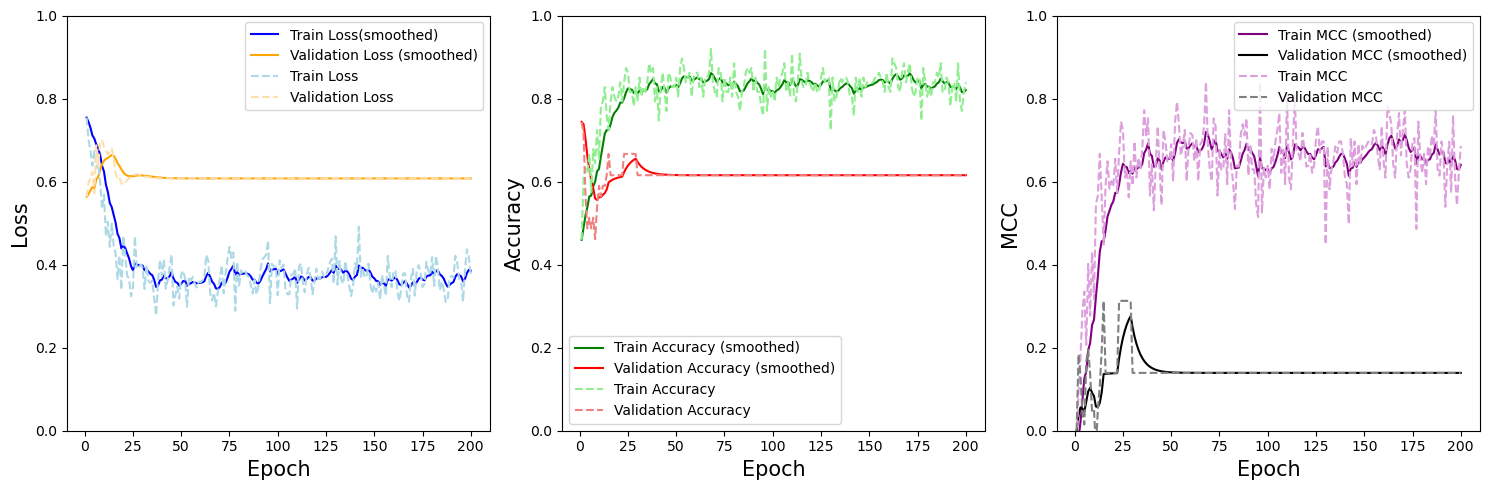

In [6]:
from torchvision.models import vgg19, VGG19_Weights
from torchvision import transforms, models

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Define the VGG-19 model
model = models.vgg19(weights=VGG19_Weights.DEFAULT)

# Modify the classifier part of the model
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2)

# layer number
total_layers = len(list(model.features.children()))

# freeze 50% layer
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.features.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False
# ---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 200
batch_size = 32
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

vgg19 = train_custom_model(model, train_dataset, val_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)


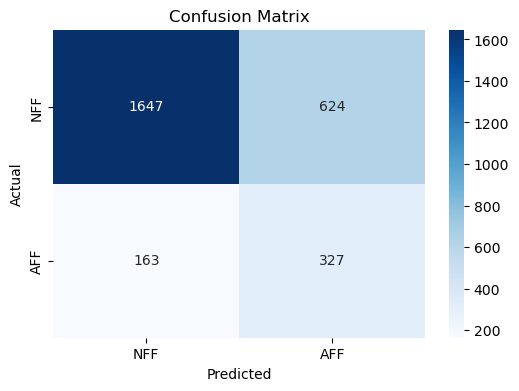

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      2271
           1       0.34      0.67      0.45       490

    accuracy                           0.71      2761
   macro avg       0.63      0.70      0.63      2761
weighted avg       0.81      0.71      0.74      2761



{'Total Acc': 0.715,
 'nff Acc': 0.725,
 'aff Acc': 0.667,
 'Precision': 0.344,
 'Recall': 0.667,
 'Accuracy': 0.715,
 'AUC': 0.696,
 'MCC': 0.316,
 'F1 Score': 0.454,
 'ROC_AUC': 0.696,
 'PRC-AUC': 0.289}

In [7]:
model = vgg19
model.eval()
# 加载测试数据集
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_csv_file = "/local/data1/honzh/local_repository/FL/code/4_federated/csv_files/test_data.csv"

test_dataset = CustomDatasetCSV(csv_file=test_csv_file, transform=test_transform)

test_model(model, test_dataset)

# ResNet50 50% freezed

Epoch 1/200, Train Loss: 0.6834, Train ACC: 0.55, Train MCC: 0.1859, Val Loss: 0.7011, Val ACC: 0.38, Val MCC: 0.1216
Epoch 2/200, Train Loss: 0.6651, Train ACC: 0.63, Train MCC: 0.3201, Val Loss: 0.6835, Val ACC: 0.46, Val MCC: 0.1370
Epoch 3/200, Train Loss: 0.6557, Train ACC: 0.69, Train MCC: 0.3721, Val Loss: 0.6776, Val ACC: 0.44, Val MCC: -0.0186
Epoch 4/200, Train Loss: 0.6364, Train ACC: 0.67, Train MCC: 0.3464, Val Loss: 0.6710, Val ACC: 0.44, Val MCC: -0.0186
Epoch 5/200, Train Loss: 0.6641, Train ACC: 0.62, Train MCC: 0.2295, Val Loss: 0.6627, Val ACC: 0.49, Val MCC: 0.0425
Epoch 6/200, Train Loss: 0.6127, Train ACC: 0.74, Train MCC: 0.4420, Val Loss: 0.6564, Val ACC: 0.49, Val MCC: 0.0425
Epoch 7/200, Train Loss: 0.5931, Train ACC: 0.72, Train MCC: 0.4296, Val Loss: 0.6710, Val ACC: 0.49, Val MCC: 0.0425
Epoch 8/200, Train Loss: 0.5772, Train ACC: 0.74, Train MCC: 0.4420, Val Loss: 0.6873, Val ACC: 0.49, Val MCC: 0.0425
Epoch 9/200, Train Loss: 0.5570, Train ACC: 0.72, Trai

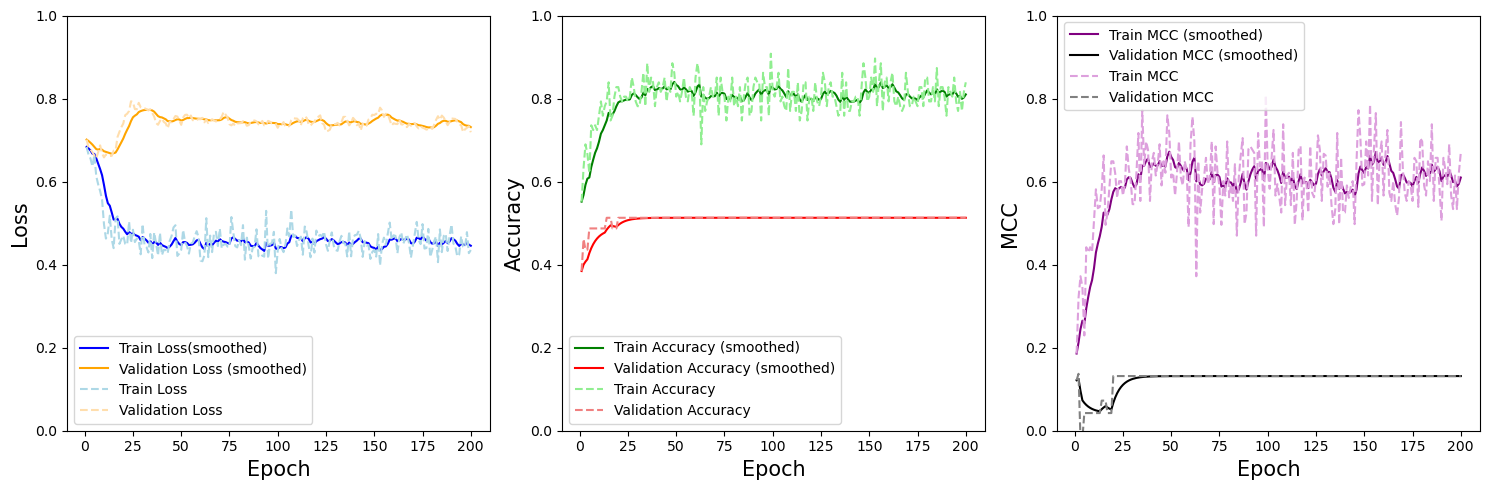

In [8]:
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms, models

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# layer number
total_layers = len(list(model.children()))

# freeze 50% layer
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False

# modify full connection layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

#---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 200
batch_size = 32
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

res50 = train_custom_model(model, train_dataset,val_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)


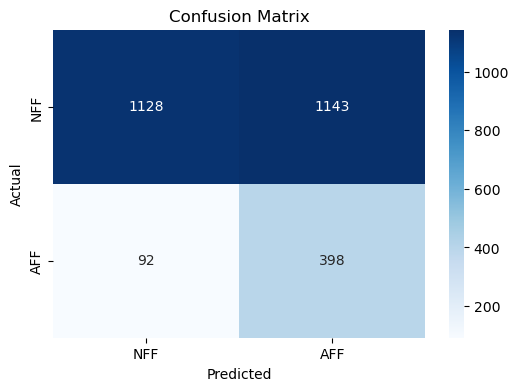

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.50      0.65      2271
           1       0.26      0.81      0.39       490

    accuracy                           0.55      2761
   macro avg       0.59      0.65      0.52      2761
weighted avg       0.81      0.55      0.60      2761



{'Total Acc': 0.553,
 'nff Acc': 0.497,
 'aff Acc': 0.812,
 'Precision': 0.258,
 'Recall': 0.812,
 'Accuracy': 0.553,
 'AUC': 0.654,
 'MCC': 0.238,
 'F1 Score': 0.392,
 'ROC_AUC': 0.654,
 'PRC-AUC': 0.243}

In [9]:
model = res50
model.eval()
# 加载测试数据集
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_csv_file = "/local/data1/honzh/local_repository/FL/code/4_federated/csv_files/test_data.csv"

test_dataset = CustomDatasetCSV(csv_file=test_csv_file, transform=test_transform)

test_model(model, test_dataset)

# ResNet 101

Epoch 1/200, Train Loss: 0.7037, Train ACC: 0.59, Train MCC: -0.0571, Val Loss: 0.6349, Val ACC: 0.69, Val MCC: 0.1931
Epoch 2/200, Train Loss: 0.6588, Train ACC: 0.71, Train MCC: 0.3611, Val Loss: 0.6057, Val ACC: 0.67, Val MCC: 0.2076
Epoch 3/200, Train Loss: 0.6643, Train ACC: 0.60, Train MCC: 0.1306, Val Loss: 0.5944, Val ACC: 0.64, Val MCC: 0.1726
Epoch 4/200, Train Loss: 0.6310, Train ACC: 0.64, Train MCC: 0.3109, Val Loss: 0.5905, Val ACC: 0.64, Val MCC: 0.2265
Epoch 5/200, Train Loss: 0.6101, Train ACC: 0.72, Train MCC: 0.4296, Val Loss: 0.5734, Val ACC: 0.62, Val MCC: 0.1943
Epoch 6/200, Train Loss: 0.6070, Train ACC: 0.67, Train MCC: 0.3052, Val Loss: 0.5586, Val ACC: 0.59, Val MCC: 0.1631
Epoch 7/200, Train Loss: 0.5422, Train ACC: 0.80, Train MCC: 0.6011, Val Loss: 0.5464, Val ACC: 0.59, Val MCC: 0.1631
Epoch 8/200, Train Loss: 0.4945, Train ACC: 0.83, Train MCC: 0.6670, Val Loss: 0.5297, Val ACC: 0.59, Val MCC: 0.1631
Epoch 9/200, Train Loss: 0.4572, Train ACC: 0.84, Train

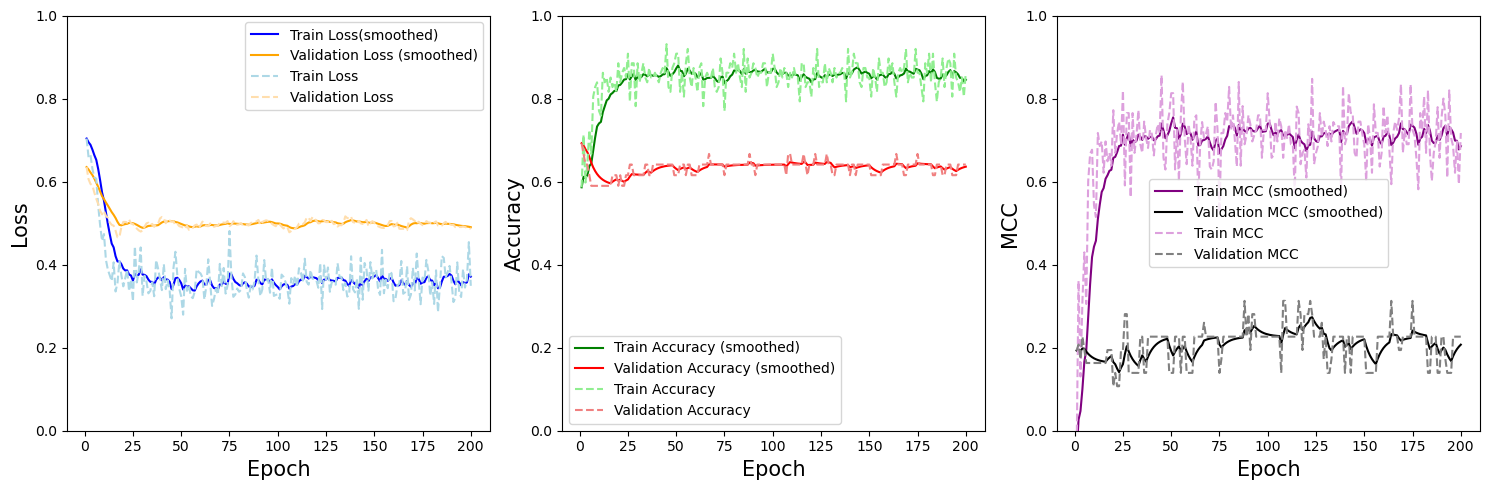

In [10]:
from torchvision.models import resnet101, ResNet101_Weights
from torchvision import transforms, models

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Define the ResNet-101 model
model = models.resnet101(weights=ResNet101_Weights.DEFAULT)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# layer number
total_layers = len(list(model.children()))

# freeze 50% layer
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False

# modify full connection layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
#---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 200
batch_size = 32
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

res101 = train_custom_model(model, train_dataset,val_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)



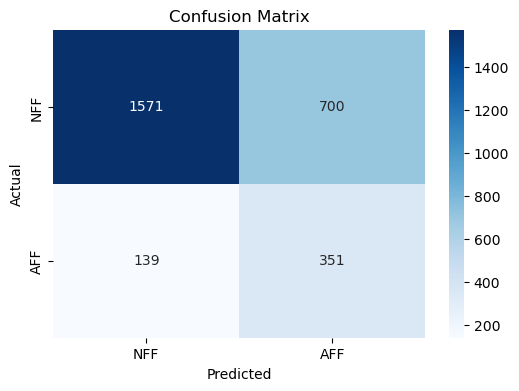

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.69      0.79      2271
           1       0.33      0.72      0.46       490

    accuracy                           0.70      2761
   macro avg       0.63      0.70      0.62      2761
weighted avg       0.81      0.70      0.73      2761



{'Total Acc': 0.696,
 'nff Acc': 0.692,
 'aff Acc': 0.716,
 'Precision': 0.334,
 'Recall': 0.716,
 'Accuracy': 0.696,
 'AUC': 0.704,
 'MCC': 0.321,
 'F1 Score': 0.456,
 'ROC_AUC': 0.704,
 'PRC-AUC': 0.29}

In [11]:
model = res101
model.eval()
# 加载测试数据集
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_csv_file = "/local/data1/honzh/local_repository/FL/code/4_federated/csv_files/test_data.csv"

test_dataset = CustomDatasetCSV(csv_file=test_csv_file, transform=test_transform)

test_model(model, test_dataset)

# densenet161

Epoch 1/200, Train Loss: 0.6520, Train ACC: 0.66, Train MCC: 0.2297, Val Loss: 0.5488, Val ACC: 0.64, Val MCC: 0.2265
Epoch 2/200, Train Loss: 0.5872, Train ACC: 0.67, Train MCC: 0.3245, Val Loss: 0.6150, Val ACC: 0.59, Val MCC: 0.2794
Epoch 3/200, Train Loss: 0.4690, Train ACC: 0.82, Train MCC: 0.6213, Val Loss: 0.7018, Val ACC: 0.56, Val MCC: 0.2510
Epoch 4/200, Train Loss: 0.4761, Train ACC: 0.72, Train MCC: 0.4484, Val Loss: 0.8018, Val ACC: 0.49, Val MCC: 0.1661
Epoch 5/200, Train Loss: 0.4184, Train ACC: 0.80, Train MCC: 0.6097, Val Loss: 0.8349, Val ACC: 0.54, Val MCC: 0.2228
Epoch 6/200, Train Loss: 0.3246, Train ACC: 0.89, Train MCC: 0.7650, Val Loss: 0.8731, Val ACC: 0.54, Val MCC: 0.2228
Epoch 7/200, Train Loss: 0.3442, Train ACC: 0.89, Train MCC: 0.7559, Val Loss: 0.9160, Val ACC: 0.51, Val MCC: 0.1946
Epoch 8/200, Train Loss: 0.4021, Train ACC: 0.82, Train MCC: 0.6382, Val Loss: 0.9537, Val ACC: 0.59, Val MCC: 0.2794
Epoch 9/200, Train Loss: 0.2135, Train ACC: 0.94, Train 

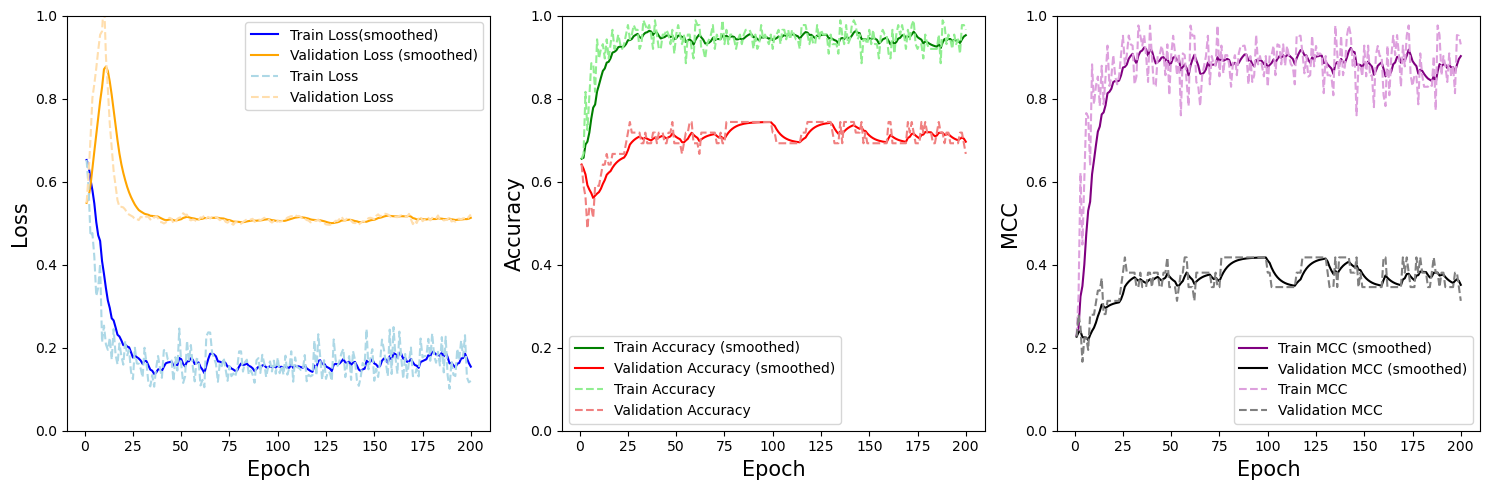

In [12]:
from torchvision.models import densenet161, DenseNet161_Weights
from torchvision import transforms, models

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Define the DenseNet-161 model
model = models.densenet161(weights=DenseNet161_Weights.DEFAULT)

# Modify the classifier part of the model
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)

# total layers 
total_layers = len(list(model.features.children()))

# freeze 50% layers
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.features.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False
#---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 200
batch_size = 32
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

dense161 = train_custom_model(model, train_dataset,val_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)   

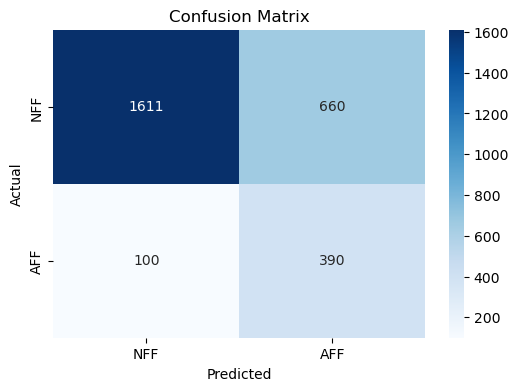

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.71      0.81      2271
           1       0.37      0.80      0.51       490

    accuracy                           0.72      2761
   macro avg       0.66      0.75      0.66      2761
weighted avg       0.84      0.72      0.76      2761



{'Total Acc': 0.725,
 'nff Acc': 0.709,
 'aff Acc': 0.796,
 'Precision': 0.371,
 'Recall': 0.796,
 'Accuracy': 0.725,
 'AUC': 0.753,
 'MCC': 0.398,
 'F1 Score': 0.506,
 'ROC_AUC': 0.753,
 'PRC-AUC': 0.332}

In [13]:
model = dense161
model.eval()
# 加载测试数据集
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_csv_file = "/local/data1/honzh/local_repository/FL/code/4_federated/csv_files/test_data.csv"

test_dataset = CustomDatasetCSV(csv_file=test_csv_file, transform=test_transform)

test_model(model, test_dataset)